In [201]:

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from os.path import join
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
from timeit import timeit
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import logging
logging.basicConfig(filename = "./output.log", filemode = "a", format='%(asctime)s:%(message)s', level=logging.DEBUG, force = True)
from functools import lru_cache
import csv
import seaborn as sns

In [202]:
# This can take a moment
# Please install git large file system before cloning
# !git lfs install

# !git clone https://github.com/juliettejahan/CapgeminiChallenge.git
# !cd CapgeminiChallenge

In [203]:
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error


FILES_FOLDER = {
    "data_for_data_challenge": [
        "data_for_data_challenge/building_data.feather",
        "data_for_data_challenge/meter_data.feather",
        "data_for_data_challenge/weather_data.feather",
        #"data_for_data_challenge/X_test_data.feather", # The dataset test will be released one hour before the end of the Data Challenge
    ],
        "clean_data": [
        "clean_data/building.csv",
        "clean_data/meters.csv",
        "clean_data/weather.csv",
        #"data_for_data_challenge/X_test_data.feather", # The dataset test will be released one hour before the end of the Data Challenge
    ]

}


def load_data(folder, data_dir, dict_files=FILES_FOLDER):
    files = dict_files[folder]
    dataframes = []
    print(":: Start loading data")
    for name_file in tqdm(files):
        dataframe = pd.read_csv(os.path.join(data_dir, name_file))
        dataframes.append(dataframe)
    return dataframes


building, meters, weather = load_data("clean_data", "./")


:: Start loading data


100%|██████████| 3/3 [00:00<00:00,  8.18it/s]


In [204]:
def process_meters(meter_df):
    meter_df = meter_df.drop(meter_df.loc[meter_df.meter == -1].index).sort_values(by=['timestamp', "building_id"])
    return meter_df



In [205]:
meters.tail(10)
print(meters.meter.unique())

#The site 0 electric meter readings are in kBTU
#count the number of buildings per meter
print("PRINTING METER COUNT")
print(meters.count())
print()
print("PRINTING METER COUNT for meter types 0,..,3")
meters.groupby('meter').count()



[0 1 3 2]
PRINTING METER COUNT
Unnamed: 0       888877
index            888877
building_id      888877
timestamp        888877
meter            888877
meter_reading    888877
dtype: int64

PRINTING METER COUNT for meter types 0,..,3


,Unnamed: 0,index,building_id,timestamp,meter_reading
meter,,,,,
0,529976,529976,529976,529976,529976
1,185703,185703,185703,185703,185703
2,123087,123087,123087,123087,123087
3,50111,50111,50111,50111,50111


In [206]:
#plot meters 0,1,2,3 reading bar plots
#sns.barplot(x = meters.meter.loc[meters.meter != 2], y = meters.meter_reading.loc[meters.meter != 2])

Abnormally high readings for meter 2. 
This meter is steam. Different unit? 


642.1246923235294


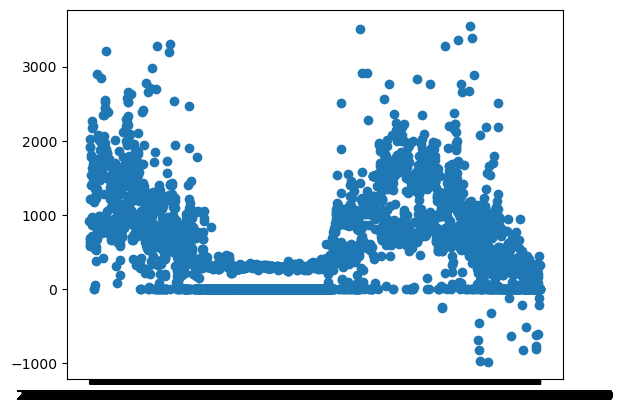

In [207]:
#sort by timestamp and draw meter reading for each time group 
#checking out outliers for meter 2
meter_quick = meters.loc[meters.meter == 2].iloc[10000:13400]
print(meter_quick['meter_reading'].mean())
meter_quick.sort_values(by = "timestamp")
plt.scatter(x =meter_quick.sort_values(by = "timestamp")['timestamp'],y = meter_quick.sort_values(by = "timestamp")['meter_reading'])



The outliers for meter two seem like erroneous readings, we should clamp them or remove them. 
Check out locs 13300 -> 13400.

In [208]:
def remove_meter2_outliers():
    qt2 = meters.groupby('meter').quantile(q = 0.75)
    qt1 = meters.groupby('meter').quantile(q = 0.25)
    qt2_meter2 = qt2.loc[2,"meter_reading"]
    qt1_meter2 = qt1.loc[2,"meter_reading"]
    #iqr based outlier removal
    iqr_meter2 = qt2_meter2 - qt1_meter2
    fence = 3*iqr_meter2
    #remove any not in fency
    #meters = meters.drop(meters.loc[meters.meter == 2 & meters.meter_reading > qt2_meter2 + fence | meters.meter_reading < qt1_meter2 - fence])
    print((meters.shape))
    meters_meter2_outliers = meters.loc[(meters.meter == 2) & ((meters.meter_reading > qt2_meter2 + fence )| (meters.meter_reading < qt1_meter2 - fence))]
    print(meters_meter2_outliers.shape)
    #i am removing 8385 lines from that have bad meter 2 (steam) values
    meters = meters.drop(meters_meter2_outliers.index)
    print(meters.shape)

def remove_meters_outliers(meters):
    qt2 = meters.groupby('meter').quantile(q = 0.75)
    qt1 = meters.groupby('meter').quantile(q = 0.25) #this is a dataframe
    iqr = qt2.meter_reading - qt1.meter_reading #this is a dataframe
    print(iqr)
    print(iqr.loc[2])
    for k in range(0,4):
        print(qt1.loc[k, 'meter_reading'])
        print(f"clipping values lower than {qt1.loc[k, 'meter_reading'] - 2*iqr.loc[k]} and greater than {qt2.loc[k,'meter_reading'] + 2*iqr.loc[k]}")
        filter_meter_k = meters.loc[(meters.meter == k) & ((meters.meter_reading > qt2.loc[k, 'meter_reading'] + 2*iqr.loc[k] ) | (meters.meter_reading <qt1.loc[k, 'meter_reading'] - 2*iqr.loc[k]))]
        meters = meters.drop(filter_meter_k.index)
    return meters



In [209]:
meters2 = remove_meters_outliers(meters)

/var/folders/nf/ybg3xwmd1nn_x978qb5nl2c00000gn/T/ipykernel_5718/598932204.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  qt2 = meters.groupby('meter').quantile(q = 0.75)


meter
0    116.48575
1    327.66370
2    765.41200
3    148.65140
Name: meter_reading, dtype: float64
765.412
17.28
clipping values lower than -215.6915 and greater than 366.73725
7.2459
clipping values lower than -648.0815 and greater than 990.2370000000001
54.9
clipping values lower than -1475.924 and greater than 2351.136
0.0
clipping values lower than -297.3028 and greater than 445.9542


/var/folders/nf/ybg3xwmd1nn_x978qb5nl2c00000gn/T/ipykernel_5718/598932204.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  qt1 = meters.groupby('meter').quantile(q = 0.25) #this is a dataframe


<AxesSubplot: xlabel='meter', ylabel='meter_reading'>

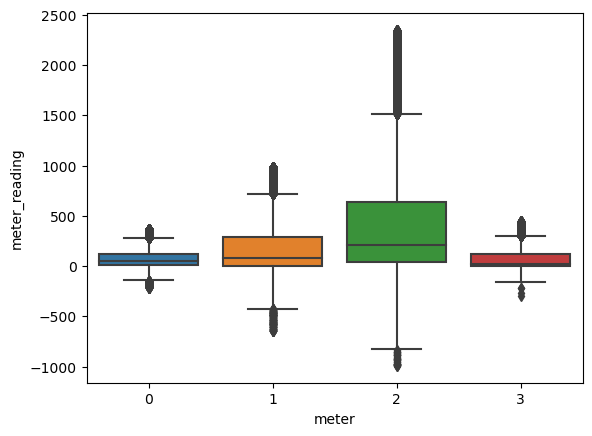

In [210]:
sns.boxplot(x = meters2.meter, y = meters2.meter_reading)

In [211]:
meters.meter.unique()

array([0, 1, 3, 2])

In [212]:
! git config --list
! git add *
! git status
! git commit -m "added TanguyNoteb"

credential.helper=osxkeychain
init.defaultbranch=main
filter.lfs.clean=git-lfs clean -- %f
filter.lfs.smudge=git-lfs smudge -- %f
filter.lfs.process=git-lfs filter-process
filter.lfs.required=true
core.repositoryformatversion=0
core.filemode=true
core.bare=false
core.logallrefupdates=true
core.ignorecase=true
core.precomposeunicode=true
remote.origin.url=https://github.com/juliettejahan/CapgeminiChallenge.git
remote.origin.fetch=+refs/heads/*:refs/remotes/origin/*
branch.main.remote=origin
branch.main.merge=refs/heads/main
lfs.repositoryformatversion=0
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   TanguyNotebook.ipynb
	new file:   output.log

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .DS_Store
	deleted:    CapgeminiChallenge
	deleted:    TanguyNo

In [213]:
# import google.colab.drive
# google.colab.drive.mount('/content/drive')

# def copytoCapG():
#     print(os.getcwd())
#     filepath="/content/drive/MyDrive/Colab Notebooks/CapgeminiChallengeExplore.ipynb"
    

In [214]:
import shutil

def copytoCapG():
    print(os.getcwd())
    src="/content/drive/MyDrive/Colab Notebooks/CapgeminiChallengeExplore.ipynb"
    print(os.listdir("/content"))
    dst = "/content/CapgeminiChallenge"
    shutil.copyfile(src, dst)




In [215]:
def plot_building(df_merged, building_id:int):
    series = df_merged.loc[df_merged.building_id == building_id]
    plt.plot(series.timestamp.loc[df_merged.meter == 0 ].iloc[::10], series.meter_reading.loc[df_merged.meter == 0 ].iloc[::10], label = 'meter 0')
    plt.show()
    return 

In [216]:
df_merged = pd.read_feather(os.path.join("./clean_data", "merged_timestamp.feather"))
df_merged.sort_values(by = ['building_id', 'timestamp'], inplace=True)

In [217]:
"""On these cells i try to find a correlation between meter0 (of which we have plenty, and the other meters.
- we could train to find meter0 with some features, train to find meter3 with other features, then run it through and sum"""
df1 = df_merged.loc[df_merged.building_id == 163]
df1.shape
df1_small = df1.iloc[10:20].copy()
df1_small.iloc[-5:,2] = 1

from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_arr = encoder.fit_transform(df1_small[['meter']]).toarray()
print(type(encoder_arr))
print(encoder_arr.dtype)
encoder_df = pd.DataFrame(encoder_arr, columns = ['meter0', "meter1", "meter3"], dtype = int)
#merge one-hot encoded columns back with original DataFrame
final_df = df1_small.join(encoder_df)
encoder_df = encoder_df.set_index(df1_small.index)
final_df = df1_small.join(encoder_df)
cols =  final_df.columns

cols = np.concatenate((cols[:3] ,cols[-2:] , cols[3:-2]))
final_df = final_df[cols]
final_df

<class 'numpy.ndarray'>
float64


,timestamp,building_id,meter,meter1,meter3,meter_reading,site_id,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,meter0
1880,2016-01-02 05:00:00,163,3,0,1,38.0992,2.0,11.7,0.0,1020.0,0.0,0.0,0
2282,2016-01-02 12:00:00,163,0,0,0,103.0600,2.0,10.0,0.6,1019.5,110.0,2.1,1
2982,2016-01-02 22:00:00,163,3,0,1,29.3071,2.0,20.6,-1.1,1017.0,100.0,3.1,0
3073,2016-01-03 00:00:00,163,3,0,1,29.3071,2.0,20.0,-1.1,1016.5,70.0,2.6,0
3255,2016-01-03 02:00:00,163,0,0,0,77.8300,2.0,16.7,-0.6,1017.0,80.0,3.6,1
3371,2016-01-03 04:00:00,163,1,1,0,13.5047,2.0,15.0,-0.6,1018.0,100.0,2.1,0
3488,2016-01-03 06:00:00,163,1,1,0,91.1900,2.0,13.3,0.6,1018.5,100.0,2.6,0
3646,2016-01-03 09:00:00,163,1,1,0,35.1685,2.0,12.2,0.6,1018.0,80.0,4.1,0
4021,2016-01-03 15:00:00,163,1,1,0,100.3300,2.0,11.7,0.0,1018.5,90.0,4.1,0
4041,2016-01-03 16:00:00,163,1,1,0,26.3764,2.0,13.3,0.6,1019.0,90.0,5.1,0


In [218]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [219]:

df1 = df_merged.loc[df_merged.building_id == 163]
df1.shape
df2 = df1.set_index(['meter', 'timestamp']).unstack(0)
df2.head(5)
cols013 = df2.iloc[:,3:6]
cols013
cols01 = cols013.iloc[:, :2] 
cols13 = cols013.iloc[:, -2:] 
cols03 = cols013.iloc[:, ::2]
(cols03.isna().sum(axis = 1) == 0 ).sum() #il y a que 128 valeurs en commun des deux meters
cols03
#where common values is False ie isna().any()
rowhasna = cols03.apply(lambda s : s.isna().any(), axis = 1)

#try to interpolate, not the best method
other = (cols03.fillna(method='ffill') + cols03.fillna(method='bfill'))/2
other = other.iloc[1:-1]
other.isna().sum(axis = 0) # il ne reste plus de na
# np.where(~rowhasna, other = )

               meter
meter_reading  0        0
               3        0
dtype: int64

                    meter_reading             
meter                           0   1        3
timestamp                                     
2016-01-01 03:00:00           NaN NaN  41.0299
2016-01-01 11:00:00         79.38 NaN  29.3071


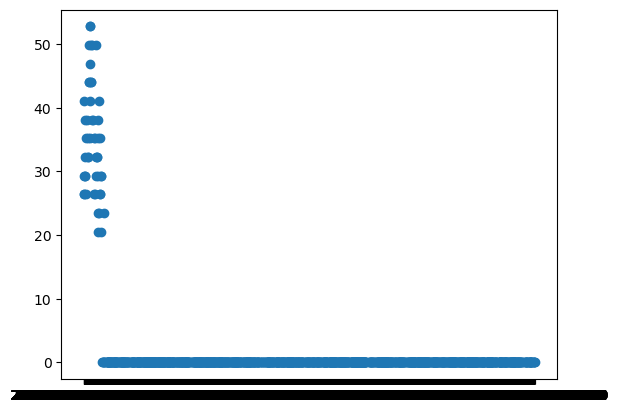

In [220]:

# sns.baplot(x = df1.loc['timestamp'], y = df1.loc[] )#meter3 reading
print(cols013.head(2))
cols013.describe()
#cols013 = cols013.replace(to_replace=0, value =np.nan)

""" other = (cols03.fillna(method='ffill') + cols03.fillna(method='bfill'))/2
other = other.iloc[1:-1]
other """

plt.scatter(x = cols013.index , y = cols013.iloc[:,2])
#sns.barplot(x = cols013.index, y = cols013.iloc[:,2])

In [221]:
#method1 : using just the values in common
cols03 = cols03.dropna(axis = 0, how = 'any')
import statsmodels.api as sm
import statsmodels.formula.api as smf
Xc = sm.add_constant(cols03.iloc[:,1])
linear_regression = sm.OLS(cols03.iloc[:,0],cols03.iloc[:,1])
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     ('meter_reading', 0)   R-squared (uncentered):                   0.031
Model:                              OLS   Adj. R-squared (uncentered):              0.023
Method:                   Least Squares   F-statistic:                              4.006
Date:                  Wed, 26 Oct 2022   Prob (F-statistic):                      0.0475
Time:                          20:41:14   Log-Likelihood:                         -781.57
No. Observations:                   128   AIC:                                      1565.
Df Residuals:                       127   BIC:                                      1568.
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
('meter_reading', 3)     2.8535      1.426      2.001      0.047       0.032       5.675
==============================================================================
Omnibus:                       49.780   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.492
Skew:                          -1.350   Prob(JB):                     3.19e-41
Kurtosis:                       8.261   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

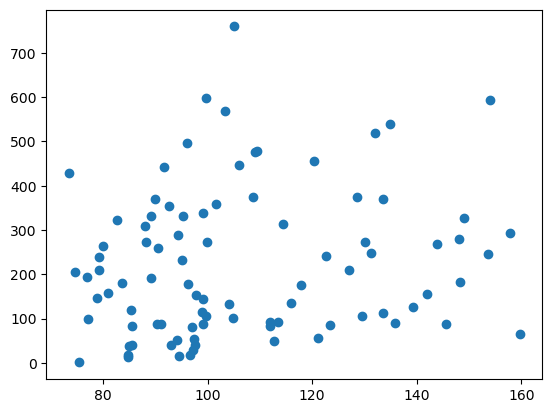

In [222]:
cols01 = cols01.replace(to_replace=0,value=np.nan)
cols01 = cols01.dropna(axis = 0, how = 'any')
cols01.shape
plt.scatter(x =cols01.iloc[:,0], y = cols01.iloc[:,1] )
#il ne semble pas y avoir de corrélation entre meter 0 et 1 


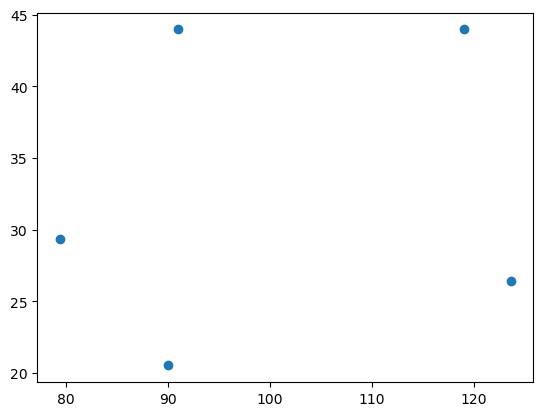

In [223]:
cols03 = cols03.replace(to_replace=0,value=np.nan)
cols03 = cols03.dropna(axis = 0, how = 'any')
cols03.shape
plt.scatter(x =cols03.iloc[:,0], y = cols03.iloc[:,1] )
#no correlation at all :(

<AxesSubplot: >

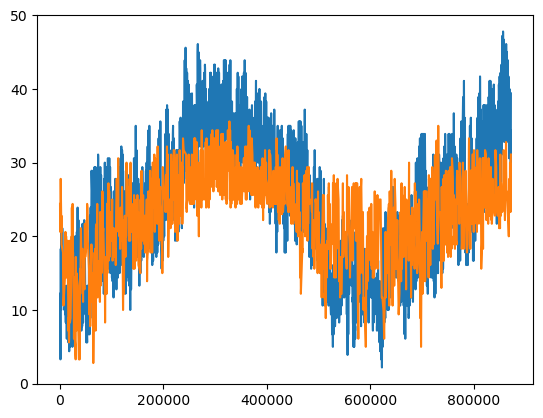

In [97]:



df1.air_temperature.plot()
df_merged.loc[df_merged.building_id == 1].air_temperature.plot()

In [98]:
dict_site_id = {
    0 : (1,0),
    1 : (0,1),
    2 : (1,0),
    3 : (1,0),
    4 : (1,0),
    5 : (0,1),
    6 : (1,0),
    7 : (1,0),
    8 : '',
    9 : (1,0),
    10 : '',
    11 : '',
    12 : (0,1),
    13 : (1,0),
    14 : '',
    15 : (1,0)
} #EU (0,1), US (1,0)

# Creation de quelques features

- one hot primary_use: 0 or 1
- square feet : float
- air temperature: float
- in Europe? : 0 or 1  

In [ ]:
df_merged = pd.read_feather(os.path.join("./clean_data", "merged_timestamp.feather"))
df_merged.sort_values(by = ['building_id', 'timestamp'], inplace=True)

In [225]:
def merge_primary_use_to_df(df_merged):
    """Since df_merged does not have primary use, i added it"""
    df_merged['primary_use'] = ''
    for k in df_merged.building_id.unique():
        df_merged.loc[df_merged.building_id == k, "primary_use"] = building.loc[building.building_id == k, "primary_use"].values[0]
    return df_merged
df_merged = merge_primary_use_to_df(df_merged)

In [226]:
df1_143 = df_merged.loc[(df_merged.building_id == 1) |(df_merged.building_id == 143) ]
print(df1_143.shape)
#add the building primary uses in one hot 
building1_143 = building.loc[(building.building_id == 1) | (building.building_id == 143)]
print(building1_143.columns)


df_merged.head()
df_merged.primary_use.unique().__len__()

#building1_143.loc[building1_143.building_id == 1, "primary_use"]

(2639, 11)
Index(['Unnamed: 0', 'index', 'site_id', 'building_id', 'primary_use',
       'sub_primary_use', 'square_feet', 'lat', 'lng', 'year_built'],
      dtype='object')


15

In [230]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_arr = encoder.fit_transform(df_merged[['primary_use']]).toarray()

list_primary_uses = df_merged.primary_use.unique()
primaryuse1hot = pd.DataFrame(encoder_arr, columns= list_primary_uses, index = df_merged.index)
#primaryuse1hot

df_merged.join(primaryuse1hot)


,timestamp,building_id,meter,meter_reading,site_id,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,...,Parking,Warehouse/storage,Religious worship,Public services,Healthcare,Utility,Technology/science,Manufacturing/industrial,Services,Food sales and service
101,2016-01-01 01:00:00,1,0,0.000,0.0,24.4,21.1,1020.0,70.0,1.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,2016-01-01 03:00:00,1,0,0.000,0.0,21.1,20.6,1020.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,2016-01-01 08:00:00,1,0,0.000,0.0,20.6,20.0,1018.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1229,2016-01-01 18:00:00,1,0,0.000,0.0,27.8,20.0,1018.0,200.0,5.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1411,2016-01-01 21:00:00,1,0,0.000,0.0,27.8,18.3,1017.0,220.0,4.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870135,2017-06-29 11:00:00,1448,0,3.100,15.0,16.7,11.7,1018.5,160.0,3.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
870528,2017-06-29 17:00:00,1448,0,2.600,15.0,25.6,16.7,NaN,200.0,4.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
870871,2017-06-29 22:00:00,1448,0,1.875,15.0,25.6,17.8,NaN,170.0,3.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872207,2017-06-30 18:00:00,1448,0,2.275,15.0,25.0,22.2,1012.0,220.0,5.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
def test1onehot():
    df1_143.sort_values(by = 'timestamp', inplace =True )
    df1_143_small=df1_143.iloc[8:20]
    #perform one-hot encoding on 'team' column 
    encoder_arr = encoder.fit_transform(df1_143_small[['primary_use']]).toarray()
    print(encoder_arr)
    print(df1_143_small.primary_use)
    print(df1_143_small.primary_use.unique())
    primaryuse1hot = pd.DataFrame(encoder_arr, columns= df1_143_small.primary_use.unique())
primaryuse1hot.head()

,Education,Office
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [240]:
from sklearn.preprocessing import OneHotEncoder
df_merged = pd.read_feather(os.path.join("./clean_data", "merged_timestamp.feather"))
df_merged.sort_values(by = ['building_id', 'timestamp'], inplace=True)
def merge_primary_use_one_hot_to_df(df_merged):
    """Since df_merged does not have primary use, i added it"""
    df_merged['primary_use'] = ''
    df_merged["square_feet"] =0.

    for k in df_merged.building_id.unique():
        df_merged.loc[df_merged.building_id == k, "primary_use"] = building.loc[building.building_id == k, "primary_use"].values[0]
        df_merged.loc[df_merged.building_id == k, "square_feet"] = building.loc[building.building_id == k, "square_feet"].values[0]

    #creating instance of one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    #perform one-hot encoding on 'team' column 
    encoder_arr = encoder.fit_transform(df_merged[['primary_use']]).toarray()
    list_primary_uses = df_merged.primary_use.unique()
    primaryuse1hot = pd.DataFrame(encoder_arr, columns= list_primary_uses, index = df_merged.index)
    #primaryuse1hot
    df_merged = df_merged.join(primaryuse1hot)
    return df_merged

df_merged=merge_primary_use_one_hot_to_df(df_merged)

In [242]:
#	- one hotted primary uses, square feet, air temperature, for the data that has meter0, inEurope?
df_merged.head()

,timestamp,building_id,meter,meter_reading,site_id,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,...,Parking,Warehouse/storage,Religious worship,Public services,Healthcare,Utility,Technology/science,Manufacturing/industrial,Services,Food sales and service
101,2016-01-01 01:00:00,1,0,0.0,0.0,24.4,21.1,1020.0,70.0,1.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,2016-01-01 03:00:00,1,0,0.0,0.0,21.1,20.6,1020.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,2016-01-01 08:00:00,1,0,0.0,0.0,20.6,20.0,1018.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1229,2016-01-01 18:00:00,1,0,0.0,0.0,27.8,20.0,1018.0,200.0,5.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1411,2016-01-01 21:00:00,1,0,0.0,0.0,27.8,18.3,1017.0,220.0,4.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['timestamp', 'building_id', 'meter', 'meter_reading', 'site_id',
       'air_temperature', 'dew_temperature', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'primary_use', 'square_feet',
       'Education', 'Office', 'Lodging/residential',
       'Entertainment/public assembly', 'Retail', 'Parking',
       'Warehouse/storage', 'Religious worship', 'Public services',
       'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services', 'Food sales and service'],
      dtype='object')


,timestamp,air_temperature,square_feet,Education,Office,Lodging/residential,Entertainment/public assembly,Retail,Parking,Warehouse/storage,Religious worship,Public services,Healthcare,Utility,Technology/science,Manufacturing/industrial,Services,Food sales and service
101,2016-01-01 01:00:00,24.4,2720.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,2016-01-01 03:00:00,21.1,2720.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,2016-01-01 08:00:00,20.6,2720.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1229,2016-01-01 18:00:00,27.8,2720.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1411,2016-01-01 21:00:00,27.8,2720.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Splitting Data
- into labels, features
- into train and test

In [257]:
print(df_merged.columns)
cols_features = [ "air_temperature",'square_feet',
       'Education', 'Office', 'Lodging/residential',
       'Entertainment/public assembly', 'Retail', 'Parking',
       'Warehouse/storage', 'Religious worship', 'Public services',
       'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services', 'Food sales and service'] # i had to remove timestamp
       
df_merged_features = df_merged.loc[df_merged.meter == 0,cols_features]
df_merged_labels = df_merged.loc[df_merged.meter == 0,"meter_reading"]
df_merged_labels

Index(['timestamp', 'building_id', 'meter', 'meter_reading', 'site_id',
       'air_temperature', 'dew_temperature', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'primary_use', 'square_feet',
       'Education', 'Office', 'Lodging/residential',
       'Entertainment/public assembly', 'Retail', 'Parking',
       'Warehouse/storage', 'Religious worship', 'Public services',
       'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services', 'Food sales and service'],
      dtype='object')


101       0.000
243       0.000
551       0.000
1229      0.000
1411      0.000
          ...  
870135    3.100
870528    2.600
870871    1.875
872207    2.275
872374    2.375
Name: meter_reading, Length: 516445, dtype: float64

In [255]:
xtrain, xtest, ytrain,ytest = train_test_split(df_merged_features, df_merged_labels, test_size= 0.2, random_state=42)
xtrain.shape
ytest.shape


(103289,)

Random forest parameters to look at: 
- n_estimators
- criterion - gini or entropy -> gini is better
- max_depth - most important parameter - how long is the tree? It is better to have many small trees and to combine them
-

In [256]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
#parameters to change
n_trees = 10
depth = 10
classifier = RandomForestRegressor(bootstrap = True, n_estimators = n_trees, max_depth= depth)
classifier.fit(xtrain, ytrain)
ypred = classifier.predict(xtest)
err = mean_absolute_percentage_error(ytest, ypred)
print(err)


1.3957588973382844e+16


In [258]:
#find . -name .DS_Store -print0 | xargs -0 git rm -f --ignore-unmatch
#removes ds store from everything

How to remove ds_Store from everything:

#find . -name .DS_Store -print0 | xargs -0 git rm -f --ignore-unmatch
